# Utilização do XGBoost em problemas de marketing

Os dados utilizados nesse script foram obtidos no site: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing. Nele, encontram-se as descrições das variáveis a serem utilizadas - o problema, em geral, consiste em criar um modelo de machine learning capaz de predizer se dado cliente irá cair ou não na campanha de marketing utilizada pela empresa

In [20]:
import os
import pandas as pd

os.chdir('C:/Users/mathe/Downloads/bank/')


dados = pd.read_csv('bank.csv', sep=';')

dados.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [21]:
dados = pd.get_dummies(dados, columns=['job', 'marital', 'education', 'housing', 'loan', 'contact',
                                       'default', 'month', 'poutcome'], drop_first=True)

dados.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,no,0,0,...,0,0,0,0,0,1,0,0,0,1
1,33,4789,11,220,1,339,4,no,0,0,...,0,0,0,1,0,0,0,0,0,0
2,35,1350,16,185,1,330,1,no,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1476,3,199,4,-1,0,no,0,0,...,0,1,0,0,0,0,0,0,0,1
4,59,0,5,226,1,-1,0,no,1,0,...,0,0,0,1,0,0,0,0,0,1


In [22]:
dados.y.replace('no', value=0, inplace=True)
dados.y.replace('yes', value=1, inplace=True)

In [23]:
from sklearn.model_selection import train_test_split

dados_train, dados_test = train_test_split(dados, test_size=0.3)


print('\nDimensõe das amostras:\nTreino: ', dados_train.shape, ' | Teste: ', dados_test.shape)


Dimensõe das amostras:
Treino:  (3164, 43)  | Teste:  (1357, 43)


As amostras possuem 43 features, sendo uma a variável resposta. 

Agora, utilizaremos o algoritmo do XGBoost para montar um modelo preditivo capaz de identificar quando um cliente irá ser fisgado pela campanha de marketing ou não

O algoritmo do XGBoost foi escolhido, pois é uma das técnicas mais utilizadas em competições do site do Kaggle

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from xgboost import XGBClassifier

modelo = XGBClassifier()

ScoresCV = cross_val_score(modelo, X=dados_train.drop('y', axis=1), y=dados_train.y,
                           cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5))

No handles with labels found to put in legend.


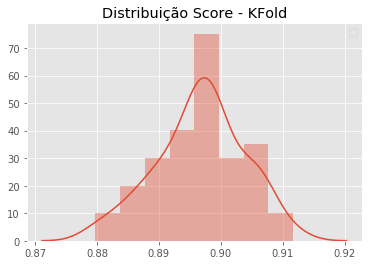

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')
sns.distplot(ScoresCV)
plt.title('Distribuição Score - KFold'); plt.legend()

Repetimos a validação cruzada estratificada 10 vezes para obtermos uma amostra do score obtido pelo algoritmo XGBoost. Com o histograma da distribuição dos mesmos, podemos fazer inferências estatísticas sobre a capacidade preditiva do modelo utilozado. Pelo gráfico, é esperado que o acerto médio fique próximo dos valores de 0.890 ou 0.90

Após a etapa anterior, utilizaremos a função da Grid Search para otimizar os hiperparâmetros do XGBoost e, então, utilizar ao modelo para predizer a amostra de teste

In [52]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

hiper_par = {'n_estimators' : [100, 200, 500, 1000],
            'learning_rate' : [1e-05, 1e-03, 1e-02, 1e-01, 1]}

ModeloGrid = GridSearchCV(modelo, param_grid=hiper_par, cv=StratifiedKFold(5), scoring='f1')


ModeloGrid.fit(X=dados_train.drop('y', axis=1), y=dados_train.y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 500, 1000], 'learning_rate': [1e-05, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [53]:
print('\nParâmetros escolhidos:\n\n', ModeloGrid.best_params_)


Parâmetros escolhidos:

 {'learning_rate': 1, 'n_estimators': 200}


Com a etapa da grid search concluída, classificaremos a amostra teste

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

predicoes = ModeloGrid.predict(dados_test.drop('y', axis=1))

print(
    confusion_matrix(dados_test.y, predicoes), '\n\n\n', classification_report(dados_test.y, predicoes)
)

[[1144   45]
 [  95   73]] 


               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1189
           1       0.62      0.43      0.51       168

   micro avg       0.90      0.90      0.90      1357
   macro avg       0.77      0.70      0.73      1357
weighted avg       0.89      0.90      0.89      1357



Considerando os resultados, temos que o acerto médio (na amostra de teste) ficou em 90% - número próximo ao estimado na etapa da validação cruzada. Temos, também, que o modelo obteve um acerto de 96% para a classe 0 e 43% para a classe 1, respectivamente